In [ ]:
import pandas as pd
import numpy as np
data = pd.read_csv('titanic3.csv')
print(data)



      pclass  survived                                             name  \
0          1         1                    Allen, Miss. Elisabeth Walton   
1          1         1                   Allison, Master. Hudson Trevor   
2          1         0                     Allison, Miss. Helen Loraine   
3          1         0             Allison, Mr. Hudson Joshua Creighton   
4          1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)   
...      ...       ...                                              ...   
1304       3         0                             Zabour, Miss. Hileni   
1305       3         0                            Zabour, Miss. Thamine   
1306       3         0                        Zakarian, Mr. Mapriededer   
1307       3         0                              Zakarian, Mr. Ortin   
1308       3         0                               Zimmerman, Mr. Leo   

         sex    age  sibsp  parch  ticket      fare    cabin embarked boat  \
0     female  29.00  

In [ ]:
# Replace missing data with NaN values
data.replace('?', np.nan, inplace= True)
data = data.astype({"age": np.float64, "fare": np.float64})


<Axes: xlabel='survived', ylabel='fare'>

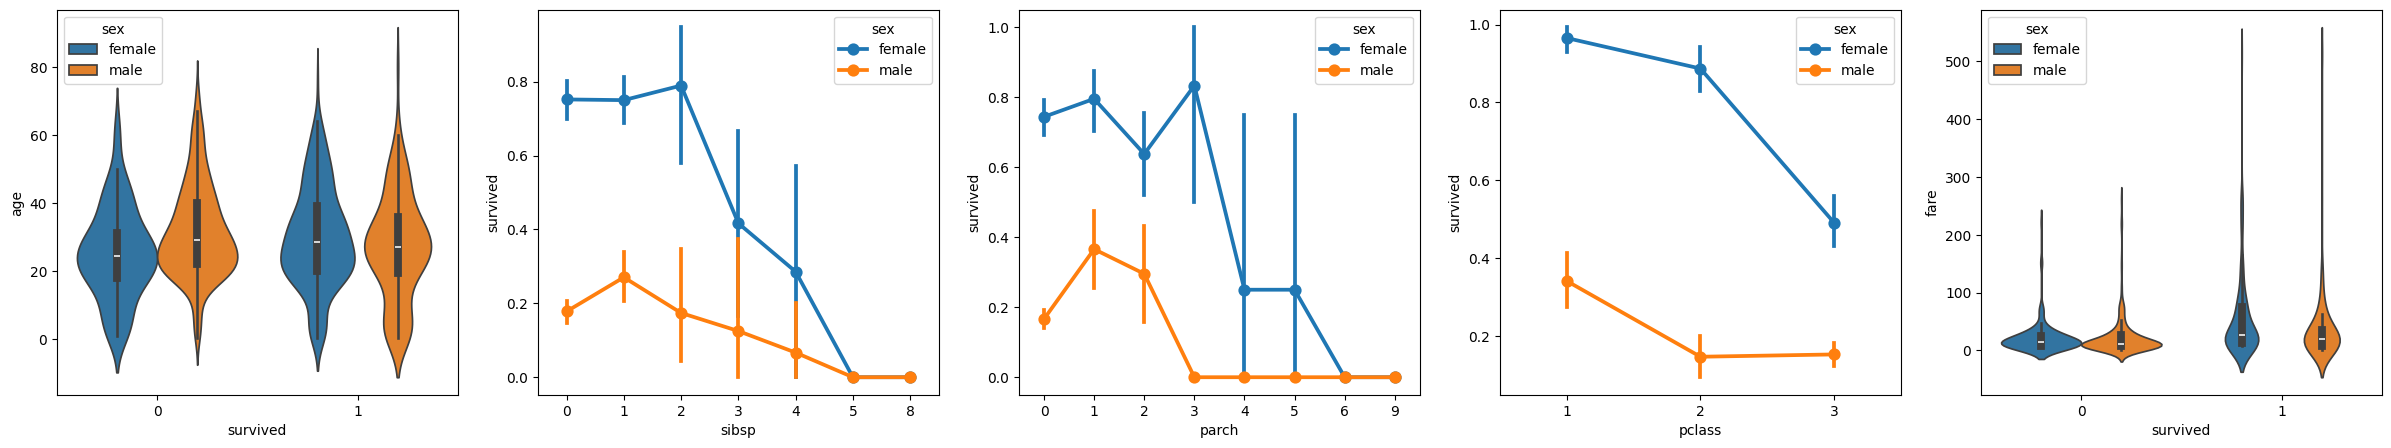

In [ ]:
# How survivability, depends on parameters
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=5, figsize=(30,5))
sns.violinplot(x="survived", y="age", hue="sex", data=data, ax=axs[0])
sns.pointplot(x="sibsp", y="survived", hue="sex", data=data, ax=axs[1])
sns.pointplot(x="parch", y="survived", hue="sex", data=data, ax=axs[2])
sns.pointplot(x="pclass", y="survived", hue="sex", data=data, ax=axs[3])
sns.violinplot(x="survived", y="fare", hue="sex", data=data, ax=axs[4])


In [ ]:
# Survivability correlation
data.replace({'male': 1, 'female': 0}, inplace=True)
data.corr(numeric_only=True).abs()[["survived"]]


C:\Users\Hos\AppData\Local\Temp\ipykernel_10944\4124169707.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({'male': 1, 'female': 0}, inplace=True)


,survived
pclass,0.312469
survived,1.000000
sex,0.528693
age,0.055512
sibsp,0.027825
parch,0.082660
fare,0.244265
body,NaN


In [ ]:
# Adding relatives collumn (siblings and parch)
data['relatives'] = data.apply (lambda row: int((row['sibsp'] + row['parch']) > 0), axis=1)
data.corr(numeric_only=True).abs()[["survived"]]


,survived
pclass,0.312469
survived,1.000000
sex,0.528693
age,0.055512
sibsp,0.027825
parch,0.082660
fare,0.244265
body,NaN
relatives,0.201719


In [ ]:
data = data[['sex', 'pclass','age','relatives','fare','survived']].dropna()

<Axes: >

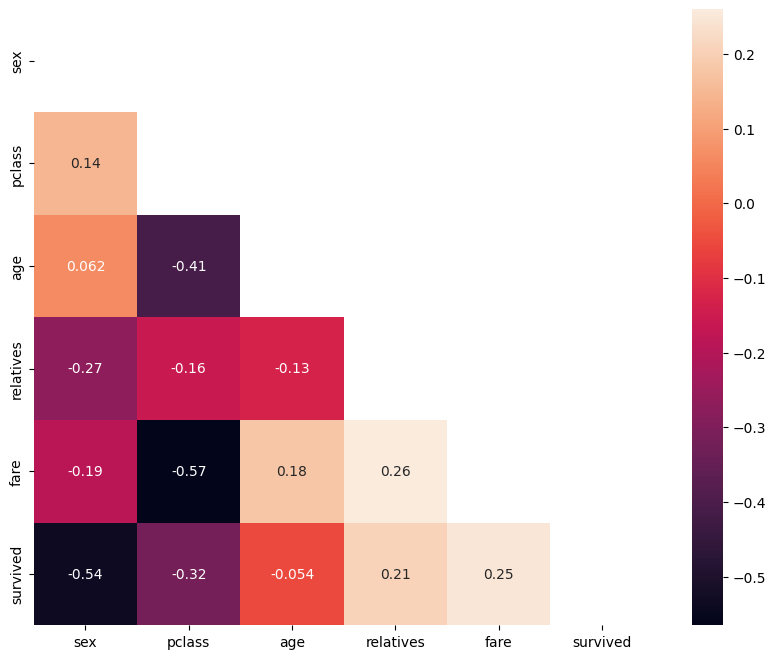

In [ ]:
# Heatmap of all correlations
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=[10,8])
sns.heatmap(data.corr(), annot=True, mask=np.triu(data.corr()))

In [ ]:
# Split dataset on training and test parts
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data[['sex','pclass','age','relatives','fare']], data.survived, test_size=0.2, random_state=0)


In [20]:
x_test

,sex,pclass,age,relatives,fare
281,0,1,43.00,1,55.4417
1267,0,3,30.00,1,24.1500
849,1,3,26.00,1,7.8542
1066,1,3,28.50,0,7.2292
109,1,1,36.00,0,26.3875
...,...,...,...,...,...
1300,0,3,15.00,1,14.4542
215,1,1,58.00,1,113.2750
322,0,1,36.00,0,135.6333
763,0,3,0.17,1,20.5750


In [ ]:
#  Normalization for better modeling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(x_train)
X_test = sc.transform(x_test)

In [ ]:
# Testing different sklearn models on Titanic dataset
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler


models_dict = { 
                # "LinearReg": LinearRegression(),
                "Neighbor": KNeighborsClassifier(),
                "DesTree": DecisionTreeClassifier(),  
                "RandForest": RandomForestClassifier(),
                "LogRegression":LogisticRegression(solver='liblinear'),
                "SVC": SVC()
              }


def to_df(data):
    column = ['mean_score', 'std', 'best_score']
    score_df = pd.DataFrame.from_dict(data, columns=column, orient='index')
    
    return score_df

model_scores = {}

for name_model, model in models_dict.items():
    score_list = []
    score = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    
    score_list.append(score.mean())
    score_list.append(score.std())
    score_list.append(score.max())
    
    model_scores[name_model] = score_list

score_df_v0 = to_df(model_scores)
score_df_v0

,mean_score,std,best_score
Neighbor,0.778672,0.047991,0.857143
DesTree,0.737923,0.043599,0.809524
RandForest,0.765491,0.034714,0.809524
LogRegression,0.777553,0.037239,0.831325
SVC,0.784682,0.039608,0.845238


In [ ]:
# Letting models to decide which variables to discard
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

model_scores = {}
best_features = {}

for name_model, model in models_dict.items():

    score_list = []
            
    sfs = SFS(model, 
                k_features=(1, 5), 
                forward=True, 
                floating=False, 
                scoring='accuracy',
                cv=5)

    sfs = sfs.fit(X_train, y_train)
            
    score_list.append(sfs.subsets_[len(sfs.k_feature_names_)]['cv_scores'].mean())
    score_list.append(sfs.subsets_[len(sfs.k_feature_names_)]['cv_scores'].std())
    score_list.append(sfs.subsets_[len(sfs.k_feature_names_)]['cv_scores'].max())

    model_scores[name_model+' cut'] = score_list

    best_features[name_model] = sfs.k_feature_names_
    
    print('model {}, score (accuracy: {}):'.format(name_model, sfs.k_score_))
    print('selected features: {}\n'.format(sfs.k_feature_names_))


score_df_v1 = to_df(model_scores)
score_df_v1

model Neighbor, score (accuracy: 0.7751211861990305):
selected features: ('0', '1', '2')

model DesTree, score (accuracy: 0.785899629312803):
selected features: ('0', '1', '2')

model RandForest, score (accuracy: 0.785906757912746):
selected features: ('0', '1', '2')

model LogRegression, score (accuracy: 0.7834901625320787):
selected features: ('0', '1', '2', '3')

model SVC, score (accuracy: 0.7966210436270316):
selected features: ('0', '1', '2', '4')



,mean_score,std,best_score
Neighbor_v1,0.775121,0.038720,0.844311
DesTree_v1,0.785900,0.025942,0.832335
RandForest_v1,0.785907,0.034436,0.832335
LogRegression_v1,0.783490,0.016707,0.802395
SVC_v1,0.796621,0.018447,0.821429


In [ ]:
# Let models change hyperparameters with GridSearch

from sklearn.model_selection import GridSearchCV

params_dict = {
                "Neighbor": {"n_neighbors": np.arange(2,10),
                        "weights": ["uniform", "distance"]},
                "DesTree": {"max_depth": np.arange(2,8), "criterion": ["gini", "entropy"],
                         "min_samples_split": np.arange(2,4),
                         "min_samples_leaf": np.arange(1,4)},
                "RandForest": {"n_estimators": np.arange(100,200,50), "max_depth": np.arange(2,6),
                       "min_samples_split": np.arange(2,7),
                      "min_samples_leaf": np.arange(2,5)},
                "LogRegression": {"max_iter": [100,200], "C": [0.01,0.05,0.1,0.2,0.5,1,1.5,2]},
                "SVC": {"C": [0.001,0.005,0.01,0.05,0.1,0.4,0.8,1],
                        "kernel": ["linear", "poly", "rbf"]}
              }
best_params_dict = {}

for name_model, model in models_dict.items():
    
    score_list = []
    
    params = params_dict[name_model]
    
    gscv = GridSearchCV(model, params, cv=5, n_jobs=-1, scoring='accuracy')    
    gscv.fit(X_train,y_train)
    score_list.append(gscv.cv_results_['mean_test_score'].mean())
    score_list.append(gscv.cv_results_['std_test_score'].mean())
    score_list.append(gscv.best_score_)
    
    model_scores[name_model+" hyp"] = score_list
    
    best_params = gscv.best_params_
    best_params_dict[name_model] = best_params
    
score_df_v2 = to_df(model_scores)
score_df_v2

,mean_score,std,best_score
Neighbor_v1,0.775121,0.038720,0.844311
DesTree_v1,0.785900,0.025942,0.832335
RandForest_v1,0.785907,0.034436,0.832335
LogRegression_v1,0.783490,0.016707,0.802395
SVC_v1,0.796621,0.018447,0.821429
Neighbor_v2,0.761650,0.025507,0.785864
DesTree_v2,0.789570,0.019365,0.802609
RandForest_v2,0.784708,0.022725,0.802616
LogRegression_v2,0.777074,0.026734,0.782293
SVC_v2,0.728068,0.018566,0.787069


In [ ]:
# Alternative model

from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [17]:
from sklearn import metrics
predict_test = model.predict(X_test)
print(metrics.accuracy_score(y_test, predict_test))


0.7464114832535885


In [ ]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()


In [ ]:
model.add(Dense(5, kernel_initializer = 'uniform', activation = 'relu', input_dim = 5))
model.add(Dense(5, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))


d:\pyth\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Test the model accuracy
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=32, epochs=50)


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5273 - loss: 0.6927
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5810 - loss: 0.6912
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5793 - loss: 0.6894
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6034 - loss: 0.6854
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6927 - loss: 0.6795
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7577 - loss: 0.6670
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7780 - loss: 0.6489
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7457 - loss: 0.6346
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7447 - loss: 0.6254
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7785 - loss: 0.5966
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7842 - loss: 0.5828
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7844 - lo

In [ ]:
y_pred = np.rint(model.predict(X_test).flatten())
print(metrics.accuracy_score(y_test, y_pred))


NameError: name 'metrics' is not defined

In [ ]:
#  Alternative approach, using LightGBM

import lightgbm as lgb
import numpy as np
rng = np.random.default_rng()
data2 = rng.uniform(size=(50, 10))  # 500 entities, each contains 10 features
label2 = rng.integers(low=0, high=2, size=(50, ))  # binary target
train_data = lgb.Dataset(data2, label=label2)

In [ ]:
param = {'num_leaves': 5, 'objective': 'binary'}
param['metric'] = 'auc'
num_round = 10
bst = lgb.train(param, train_data, num_round)

[LightGBM] [Info] Number of positive: 23, number of negative: 27
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 180
[LightGBM] [Info] Number of data points in the train set: 50, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.460000 -> initscore=-0.160343
[LightGBM] [Info] Start training from score -0.160343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L